In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# 2. Creează o clasă personalizată pentru Dataset
class DataCustom(Dataset):
    def __init__(self, csv_file, folder_root, transform=None):
        self.transformare = transform
        self.adnotari = pd.read_csv(csv_file)
        self.folder_root = folder_root

    def __len__(self):
        return len(self.adnotari)

    def __getitem__(self, id): # se surprascrie metoda pentru a putea folosi dataLoader
        ruta = f'{self.folder_root}/{self.adnotari.iloc[id, 0]}.png'
        image = Image.open(ruta).convert("RGB")
        eticheta = None
        if self.folder_root != 'Data/test':
            eticheta = int(self.adnotari.iloc[id, 1])

        if self.transformare:
            image = self.transformare(image)

        return image, eticheta

In [3]:
transformare = transforms.Compose([
    transforms.Resize((80, 80)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(80, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[1, 1, 1]) # scadem doar media, nu mai impartim si la deviatia standard
])

In [4]:
fisier = 'Data/train.csv'
data_df = pd.read_csv(fisier)
folder_root = 'Data/train'
train_data = DataCustom(csv_file=fisier, root_dir=folder_root, transform=transformare)

fisier = 'Data/validation.csv'
data_df = pd.read_csv(fisier)
folder_root = 'Data/validation'
validation_data = DataCustom(csv_file=fisier, root_dir=folder_root, transform=transformare)

fisier = 'Data/test.csv'
data_df = pd.read_csv(fisier)
folder_root = ('Data/test')
test_data = DataCustom(csv_file=fisier, root_dir=folder_root, transform=transformare)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


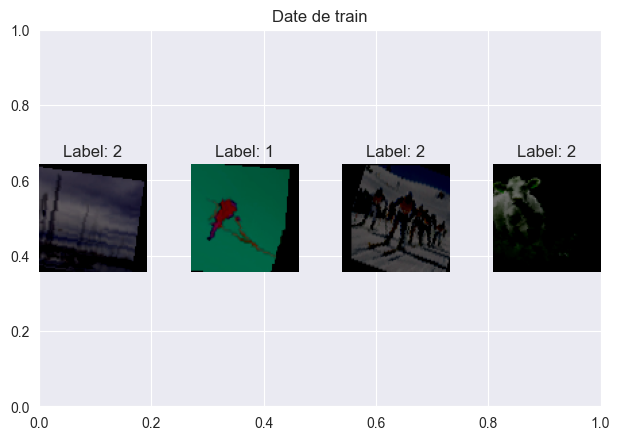

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


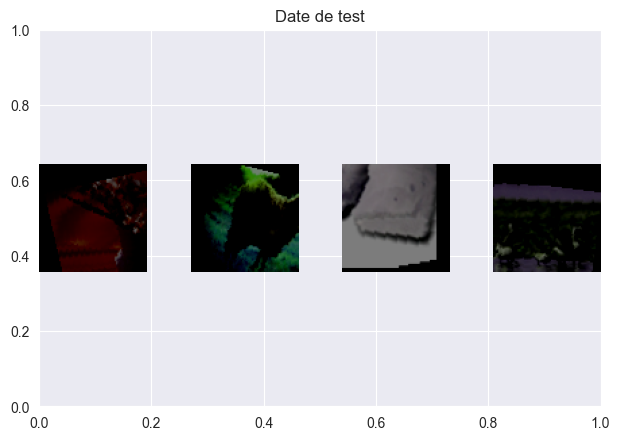

In [5]:
fig = plt.figure()
plt.title("Date de train")
# plotam cateva imagini de antrenare

for i in range(len(train_data)):
    image, label = train_data[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Label: %d' % label)
    ax.axis('off')
    plt.imshow(image.permute(1, 2, 0))
    if i == 3:
        break
plt.show()
# plotam cateva imagini de test
fig = plt.figure()
plt.title("Date de test")
for i in range(len(test_data)):
    image = test_data[i]
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.axis('off')
    plt.imshow(image[0].permute(1, 2, 0))
    if i == 3:
        break
plt.show()



In [6]:
class ReteaConv2(nn.Module):
    def __init__(self):
        super(ReteaConv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, stride=1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128,stride=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256,stride=1, kernel_size=3,  padding=1)
        self.conv4 = nn.Conv2d(256, 512,stride=1, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 3)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instanțierea modelului
rc = ReteaConv2()

In [7]:
criteriu = nn.CrossEntropyLoss()
optimizator = torch.optim.Adam(rc.parameters(), lr=0.001)
epoci = 15
# incarcarea datelor si antrenare si validare
load_train = DataLoader(train_data, batch_size=32, shuffle=True)
load_validare = DataLoader(validation_data, batch_size=32, shuffle=False)

In [8]:
evolutie_loss_validare = []
evolutie_loss_train = []
evolutie_precizie_train = []
evolutie_precizie_validare = []

In [9]:
def validate():
    rc.eval()
    val_loss = 0.0
    corect = 0
    total = 0
    torch.no_grad()# nu se calculeaza gradientul
    for input, eticheta in load_validare:
        output = rc(input)
        loss = criteriu(output, eticheta)
        val_loss += loss.item()
        _, predictie = torch.max(output, 1)
        total += eticheta.size(0)
        corect += (predictie == eticheta).sum().item()
    torch.set_grad_enabled(True) # reactivam caluculul gradientului
    print(f'Pierdere validre: {val_loss / len(load_validare)}, Precizie validare: {corect / total}')
    evolutie_loss_validare.append(val_loss / len(load_validare))
    evolutie_precizie_validare.append(corect / total)


In [10]:
for epoca in range(epoci):
    rc.train()
    pierdere_c = 0.0
    corect = 0
    for input, eticheta in load_train:
        optimizator.zero_grad()
        outputs = rc(input)
        loss = criteriu(outputs, eticheta)
        loss.backward()
        optimizator.step()
        pierdere_c += loss.item()
        _, predictie = torch.max(outputs, 1)
        corect += (predictie == eticheta).sum().item()
    validate()
    print(f"Epoca {epoca + 1}, Pierdere antrenament: {pierdere_c / len(load_train)}, Precizie antrenament: {corect / len(load_train)}")
    evolutie_loss_train.append(pierdere_c / len(load_train))
    evolutie_precizie_train.append(pierdere_c / len(load_train))

Pierdere validre: 1.1178551982057856, Precizie validare: 0.3953333333333333
Epoca 1, Pierdere antrenament: 1.140078047488598, Precizie antrenament: 13.091185410334347
Pierdere validre: 1.0632416707404115, Precizie validare: 0.4493333333333333
Epoca 2, Pierdere antrenament: 1.0754424561845495, Precizie antrenament: 13.443768996960486
Pierdere validre: 1.039151925989922, Precizie validare: 0.487
Epoca 3, Pierdere antrenament: 1.0498949430633824, Precizie antrenament: 14.887537993920972
Pierdere validre: 1.0074286492581064, Precizie validare: 0.5163333333333333
Epoca 4, Pierdere antrenament: 1.0232974979290483, Precizie antrenament: 15.714285714285714
Pierdere validre: 0.9938006718107995, Precizie validare: 0.5236666666666666
Epoca 5, Pierdere antrenament: 1.0104872173089023, Precizie antrenament: 16.221884498480243
Pierdere validre: 1.0864316605507058, Precizie validare: 0.4603333333333333
Epoca 6, Pierdere antrenament: 1.0024306096566846, Precizie antrenament: 16.376899696048632
Pierder

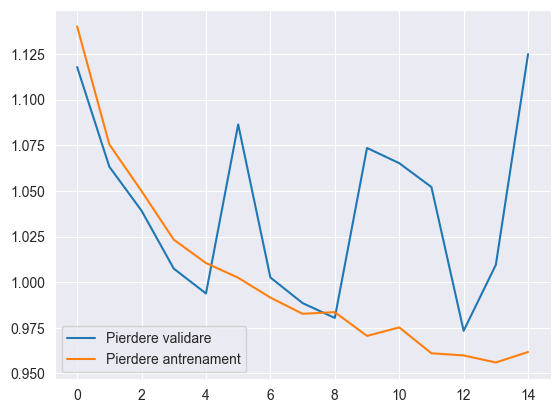

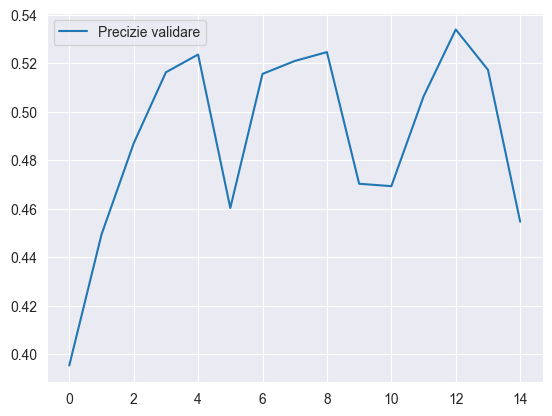

In [12]:
plt.plot(evolutie_loss_validare, label='Pierdere validare')
plt.plot(evolutie_loss_train, label='Pierdere antrenament')
plt.legend()
plt.show()

plt.plot(evolutie_precizie_validare, label='Precizie validare')
plt.legend()
plt.show()

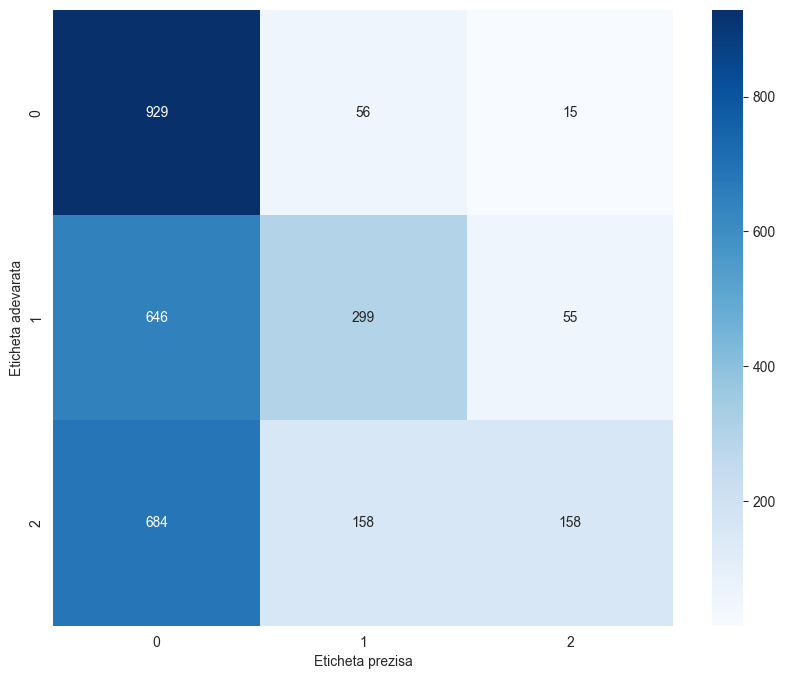

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Eticheta adevarata')
    plt.xlabel('Eticheta prezisa')
    plt.show()

rc.eval()
y_true = []
y_pred = []
for input, eticheta in load_validare:
    output = rc(input)
    _, predictie = torch.max(output, 1)
    y_true.extend(eticheta.tolist())
    y_pred.extend(predictie.tolist())

plot_confusion_matrix(y_true, y_pred, ['0', '1', '2'])